# Flood Mapping Example

This notebook provides the code to reproduce the results of the paper for what concerns the flood data.


## 0. Preamble



In [2]:
import os
import subprocess
import shutil

REPO_URL = "https://github.com/FractalySyn/PiNets-Alignment.git"
FOLDER = "floods"

if not os.path.exists(FOLDER):# or True:
    subprocess.run(
        ["git", "clone", "--filter=blob:none", "--no-checkout", "--sparse", REPO_URL, "tmp_clone"],
        check=True,
    )
    try:
        subprocess.run(["git", "-C", "tmp_clone", "sparse-checkout", "set", FOLDER], check=True)
        subprocess.run(["git", "-C", "tmp_clone", "checkout", "main"], check=True)
        shutil.copytree(os.path.join("tmp_clone", FOLDER), FOLDER, dirs_exist_ok=True)
    finally:
        shutil.rmtree("tmp_clone", ignore_errors=True)
else:
    print(f"Directory '{FOLDER}' already exists.")

Directory 'floods' already exists.


The code chunk below will download the [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset and the [Prithvi foundation model](https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M)

In [ ]:
try:
  os.mkdir('floods/external_data/')
  !gsutil -m rsync -r -x ".*(JRCWaterHand|S1OtsuLabelHand).*" gs://sen1floods11/v1.1/data/flood_events/HandLabeled/ floods/external_data/
  !gsutil -m rsync -r gs://sen1floods11/v1.1/splits/flood_handlabeled/ floods/external_data/
  
  os.mkdir('floods/external_data/prithvi/')
  !git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M floods/external_data/prithvi/
  %pip install -q rasterio
  
  print('Done downloading! The data is in the floods/external_data/ directory.')
except:
  print('The floods/external_data/ directory already exists! Skipping download. Verify that the data is present or remove the external_data/ folder and rerun.')

The floods/external_data/ directory already exists! Skipping download. Verify that the data is present or remove the external_data/ folder and rerun.


In [40]:
### Derandomization and determinism setup for reproducibibility
from floods.utils import env_reproducibility
env_reproducibility()

SEED = 2025            ## random seed for reproducibility

### Pytorch engine --- uses GPU (cuda) if available
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Satellite Data



In [41]:
import pandas as pd

DIR = 'floods/external_data/'

## we make our own split so we combine train and val sets here
train_df = pd.read_csv(DIR+'flood_train_data.csv', header=None)
val_df = pd.read_csv(DIR+'flood_valid_data.csv', header=None)
train_df = pd.concat([train_df, val_df], ignore_index=True)
del val_df

test_df = pd.read_csv(DIR+'flood_test_data.csv', header=None)

train_df.head(3)

,0,1
0,Ghana_103272_S1Hand.tif,Ghana_103272_LabelHand.tif
1,Ghana_24858_S1Hand.tif,Ghana_24858_LabelHand.tif
2,Ghana_147015_S1Hand.tif,Ghana_147015_LabelHand.tif


**Example of Sentinel-2 data and flood masks**

In [42]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## plotting setup
colors = ['black', 'lightgray', 'teal']
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5] 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

**Visualize a sample from the test set**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0       Nigeria_812045_S1Hand.tif
1    Nigeria_812045_LabelHand.tif
Name: 33, dtype: object


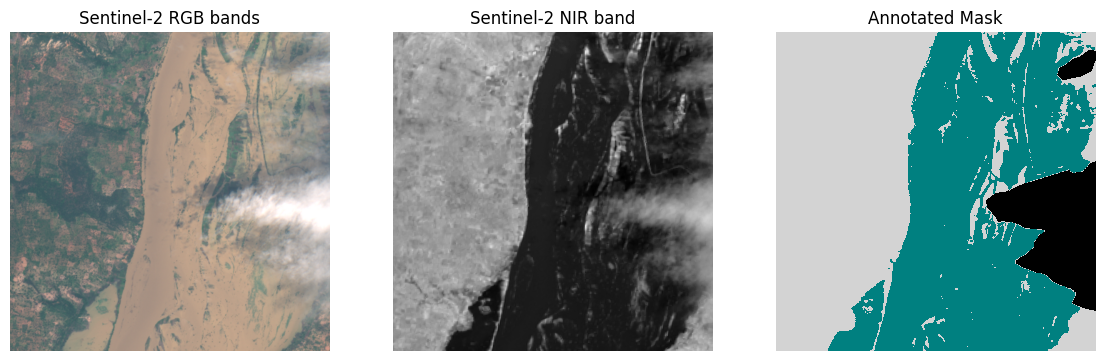

In [43]:
## visualize a sample from the test set
row = test_df.iloc[33]
print(row)

## load Sentinel-2 image and mask
S2_path = DIR+'S2Hand/' + row[0].replace('S1', 'S2')
mask_path = DIR+'LabelHand/' + row[1]
with rasterio.open(S2_path) as src:
  S2 = src.read()
with rasterio.open(mask_path) as src:
  mask = src.read(1)

## preprocess S2 for visualization
S2 = S2 / 3000.0
S2_nir = S2[8]
S2 = S2[[3,2,1]].transpose(1,2,0)

## plot
fig, axs = plt.subplots(1, 3, figsize=(14,5))
[ax.axis('off') for ax in axs]

axs[0].imshow(S2, vmax=1)
axs[1].imshow(S2_nir, cmap='gray')
axs[2].imshow(mask, cmap= cmap, norm=norm);

axs[0].set_title('Sentinel-2 RGB bands')
axs[1].set_title('Sentinel-2 NIR band')
axs[2].set_title('Annotated Mask');

**Load images in memory**

In [44]:
train_df = train_df.sample(10)

In [45]:
import numpy as np
from floods.utils import load_X, load_pi

## load data (images X and masks pi*)
X_train = np.array([load_X(row, DIR) for _, row in train_df.iterrows()])
pi_star_train = np.array([load_pi(row, DIR) for _, row in train_df.iterrows()])

X_test = np.array([load_X(row, DIR) for _, row in test_df.iterrows()])
pi_star_test = np.array([load_pi(row, DIR) for _, row in test_df.iterrows()])

We downsample the 512x512 images and masks into four insets of dimensions 256x256

In [46]:
from floods.utils import split_into_insets, flatten_data, train_val_split, seed_all

X_train_insets = split_into_insets(X_train)  
pi_star_train_insets = split_into_insets(pi_star_train)  
area_train_insets = np.stack([(pi_star_train_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

X_test_insets = split_into_insets(X_test)  
pi_star_test_insets = split_into_insets(pi_star_test)
area_test_insets = np.stack([(pi_star_test_insets==k).sum(axis=(2,3)) for k in [-1,0,1]], axis=2)

In [47]:
## Flatten data
X_train_flat, pi_star_train_flat, area_train_flat = \
  flatten_data(X_train_insets, pi_star_train_insets, area_train_insets)
X_test_flat, pi_star_test_flat, area_test_flat = \
  flatten_data(X_test_insets, pi_star_test_insets, area_test_insets)

# Train/validation split
seed_all(SEED)
X_train_flat, X_val_flat, pi_star_train_flat, pi_star_val_flat, area_train_flat, area_val_flat = \
  train_val_split(X_train_flat, pi_star_train_flat, area_train_flat, val_split=0.2)

# Prepare test scenes for visualization
S2_scenes = X_test_flat[:, [2,1,0]].permute(0,2,3,1).numpy()
S2_scenes = (S2_scenes - S2_scenes.min()) / (S2_scenes.max() - S2_scenes.min()) * (10000 / 3000)

In [48]:
from torch.utils.data import TensorDataset, DataLoader

seed_all(SEED)

## normalization
mu, sigma = X_train_flat.mean(dim=(0,2,3), keepdim=True), X_train_flat.std(dim=(0,2,3), keepdim=True)

## Create DataLoaders for pytorch
train_dataset = TensorDataset((X_train_flat-mu)/sigma, area_train_flat, pi_star_train_flat)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset((X_val_flat-mu)/sigma, area_val_flat, pi_star_val_flat)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset((X_test_flat-mu)/sigma, area_test_flat, pi_star_test_flat)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 2. Training

### 2.1. Hyperparameters 

In [64]:
import json

## Phritvi hyperparameters
with open(DIR+'prithvi/config.json', 'r') as file:
  config = json.load(file)['pretrained_cfg']

## modify config for our use case
config['mask_ratio'] = 0.0
config['img_size'] = 256
config['depth'] = 4

del config['mean'], config['std']
config

{'img_size': 256,
 'patch_size': [1, 16, 16],
 'num_frames': 3,
 'in_chans': 6,
 'embed_dim': 768,
 'depth': 4,
 'num_heads': 12,
 'decoder_embed_dim': 512,
 'decoder_depth': 8,
 'decoder_num_heads': 16,
 'mlp_ratio': 4,
 'mask_ratio': 0.0,
 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'],
 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M',
 'paper_ids': 'arXiv:2310.18660'}

In [65]:
BATCH_SIZE = 32        ## batch size for training
N_EPOCHS = 200         ## max training epochs
lr = 5e-3              ## initial learning rate
weight_decay = 5e-3    ## weight decay for optimizer
patience = 1           ## lr scheduler patience
factor = 0.2           ## lr scheduler division factor
ES = 1e-5              ## early stopping - loss threshold

load_pretrained = True   ## whether to load pretrained weights
freeze_encoder = True    ## whether to freeze encoder weights during training

In [66]:
os.makedirs('floods/models/', exist_ok=True)

### 2.2. Baseline SegNet

We train the baseline segmentation model with the binary cross entropy loss. Alternatively it can be trained with the false abstraction rate as a loss function. For this set `loss_='FAR'`

In [ ]:
from floods.models import *

class PiPrithvi(nn.Module):
  
  def __init__(self, backbone_cfg, C_out, dim_in, dim_out, DIR='', load_pretrained=True, freeze_backbone=False, device='cpu'):

    super().__init__()
    self.dim_in = dim_in
    self.dim_out = dim_out
    self.freeze_backbone = freeze_backbone
    self.ft_layers = list(range(0, backbone_cfg['depth']))[-4:]

    self.redim = lambda x, d: F.interpolate(x, size=(d, d), mode='bilinear', align_corners=False)
    self.encoder = PrithviViT(**backbone_cfg).to(device)
    self.reshape = ReshapeTokensToImage(self.ft_layers)
    self.decoder = UperNetDecoder([backbone_cfg['embed_dim']] * len(self.ft_layers), channels=32, scale_modules=True).to(device)
    self.decoder2 = Decoder(32, C_out, 64, dim_out).to(device)
    self.activ = lambda pi: F.softmax(pi, dim=1) if C_out > 1 else torch.sigmoid(pi)

    if load_pretrained:
    #   url = '/kaggle/working/Prithvi-EO-1.0-100M/Prithvi_EO_V1_100M.pt' 
      state_dict = torch.load(DIR+'Prithvi_EO_V1_100M.pt', map_location=torch.device(device))
      for k in list(state_dict.keys()):
          if 'pos_embed' in k:
              del state_dict[k]
      self.load_state_dict(state_dict, strict=False)

    if freeze_backbone:
      for param in self.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):

    if self.dim_in != x.shape[-1]:
      x = self.redim(x, self.dim_in)
    if len(x.shape) == 4:
      x = x.unsqueeze(2)
    
    if self.freeze_backbone:
      self.encoder.eval()
      with torch.no_grad():
        h = self.encoder.forward_features(x)
    else:          
      h = self.encoder.forward_features(x)

    h = [h[i] for i in self.ft_layers]
    h = self.reshape(h)
    
    pi = self.decoder(h)
    pi = self.decoder2(pi)
    pi = self.activ(pi).squeeze()

    y = pi.sum(dim=(-2,-1))
    return pi, y


In [72]:
from floods.utils import free_ram, model_size
# from floods.models import PiPrithvi

free_ram()
seed_all(SEED)

## Initialize Pi-Prithvi model
model = PiPrithvi(config, C_out=3, dim_in=config['img_size'], dim_out=256, DIR=DIR+'prithvi/',
                  load_pretrained=load_pretrained, freeze_backbone=freeze_encoder, device=device)
model.to(device)
model_size(model)

## Set loss and optimizer
loss_ = 'BCE'        # or FAR
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

path = f'models/segnet.pt'

FileNotFoundError: [Errno 2] No such file or directory: 'floods/external_data/prithvi/Prithvi_EO_V1_100M.pt'

In [ ]:
from floods.training import training

model = training(model, train_loader, val_loader, optimizer, scheduler, loss_, N_EPOCHS, device, ES=ES, path=path)